In [1]:
import json
import random

import numpy as np
import pandas as pd
import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bids = pd.read_csv('../data/bid_requests.csv')
users = pd.read_csv('../data/user_attributes.csv')

In [3]:
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   600000 non-null  object
 1   user_id     600000 non-null  object
 2   bid         600000 non-null  int64 
 3   win         600000 non-null  int64 
 4   conversion  600000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 22.9+ MB


In [4]:
bids.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In [5]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [6]:
txt = users.attributes[1]

In [7]:
dic = json.loads(txt)

In [8]:
atts = pd.DataFrame(columns=['age', 'gender', 'location', 'test'])

In the interest of time, I've commented out the next two cells:
* the first cell creates a dataframe from the attributes textblob in the users dataframe. That process is extremely slow
* in the following cell, I save that attributes dataframe as a csv, so we can just read it in whenever we re-run the notebook

Of course, if you have time on your hands, or a GPU, I invite you to uncomment out the next cell and run it at your discretion.

In [9]:
# for i in range(len(users.attributes)):
#     dic = json.loads(users.attributes[i])
    
#     for k in dic:
#         dic[k] = [dic[k]]
        
#     df = pd.DataFrame.from_dict(dic)
    
#     atts = atts.append(df, ignore_index=True)
    
        

In [10]:
# atts.to_csv('../data/atts.csv', index=False)

In [11]:
atts = pd.read_csv('../data/atts.csv')

In [12]:
atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   age       100000 non-null  int64 
 1   gender    100000 non-null  object
 2   location  100000 non-null  object
 3   test      100000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [13]:
cols = atts.columns.to_list()
cols.insert(0, 'user_id')
cols

['user_id', 'age', 'gender', 'location', 'test']

In [14]:
atts['user_id'] = users['user_id']

In [15]:
atts = atts[cols]

In [16]:
atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   100000 non-null  object
 1   age       100000 non-null  int64 
 2   gender    100000 non-null  object
 3   location  100000 non-null  object
 4   test      100000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


In [17]:
atts.user_id[0] == users.user_id[0]

True

In [18]:
atts.head()

,user_id,age,gender,location,test
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1
1,000053b1e684c9e7ea73727b2238ce18,26,M,AL,1
2,00029153d12ae1c9abe59c17ff2e0895,29,F,AR,1
3,0002ac0d783338cfeab0b2bdbd872cda,29,M,SC,0
4,0004d0b59e19461ff126e3a08a814c33,27,F,AR,1


In [19]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [20]:
control = atts[atts['test']==0]
test = atts[atts['test']==1]

In [21]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43916 entries, 3 to 99997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   43916 non-null  object
 1   age       43916 non-null  int64 
 2   gender    43916 non-null  object
 3   location  43916 non-null  object
 4   test      43916 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56084 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   56084 non-null  object
 1   age       56084 non-null  int64 
 2   gender    56084 non-null  object
 3   location  56084 non-null  object
 4   test      56084 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.6+ MB


In [26]:
d1 = control.location.value_counts().sort_index().values
d2 = test.location.value_counts().sort_index().values

dlabels = ['Control', 'Test']
labels = list(set(control.location.values))
labels.sort()
xlabel = 'State'
ylabel = 'User Count'

x = np.arange(len(labels))
width = 0.35
xticks = [x, labels]

title = 'Control and Test Group User Counts by State'

In [27]:
def makeGroupedBars(d1, d2, x, dlabels, xticks, xlabel, ylabel, title):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, d1, width, label=dlabels[0])
    rects2 = ax.bar(x + width/2, d2, width, label=dlabels[1])

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(xticks[0], xticks[1])
    ax.set_xlabel(xlabel)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.savefig(f'../images/{title.replace(" ", "_")}.png')

    plt.show()

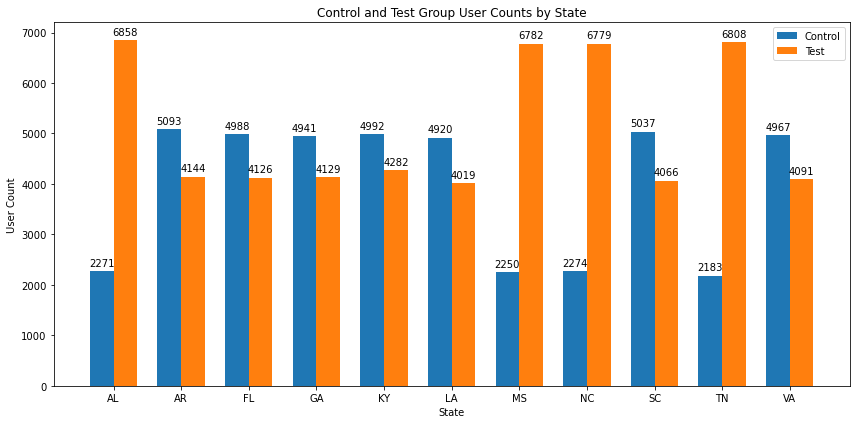

In [28]:
makeGroupedBars(d1, d2, x, dlabels, xticks, xlabel, ylabel, title)

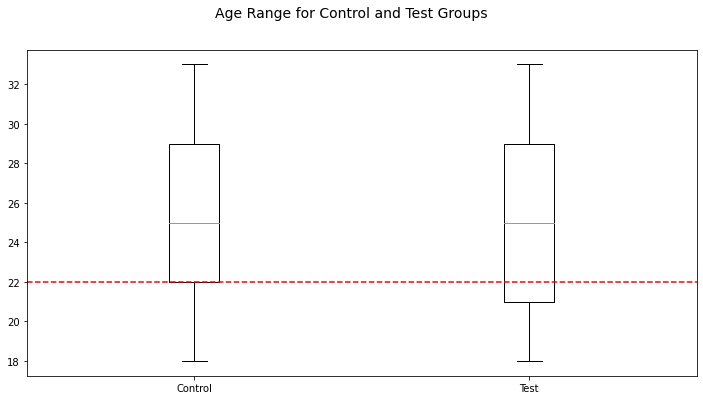

In [62]:
fig = plt.figure(figsize=(12,6))
plt.boxplot ([control.age, test.age], labels=['Control', 'Test'])
plt.axhline(y=control.age.quantile(0.25), color='r', linestyle='--')
fig.suptitle('Age Range for Control and Test Groups', fontsize=14)
plt.show()

In [27]:
control.gender.value_counts()

M    22101
F    21815
Name: gender, dtype: int64

In [28]:
test.gender.value_counts()

F    28108
M    27976
Name: gender, dtype: int64

In [29]:
control_bids = bids[bids['user_id'].isin(control.user_id.values)]

In [30]:
test_bids = bids[bids['user_id'].isin(test.user_id.values)]

In [31]:
control_bids.describe()

,bid,win,conversion
count,262107.000000,262107.000000,262107.000000
mean,0.499777,0.250142,0.010389
std,0.500001,0.433096,0.101395
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [32]:
test_bids.describe()

,bid,win,conversion
count,337893.000000,337893.000000,337893.000000
mean,0.499703,0.250360,0.010039
std,0.500001,0.433221,0.099689
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [33]:
bids.describe()

,bid,win,conversion
count,600000.000000,600000.000000,600000.000000
mean,0.499735,0.250265,0.010192
std,0.500000,0.433166,0.100438
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [34]:
(test_bids.conversion.mean() * 100) - (control_bids.conversion.mean() * 100)

-0.03502060970857768

In [35]:
(control_bids.conversion.mean() * 100) - (bids.conversion.mean() * 100)

0.019722031460434053

In [36]:
(test_bids.conversion.mean() * 100) - (bids.conversion.mean() * 100)

-0.015298578248143624

# A / B Testing to Evaluate Campaign Performance

Comparing the conversion rate (mean conversion value for conversion column) for the control and test groups, we actually see a decline in conversion in the test group, suggesting that the new ad decreases conversion.

We can confirm whether this decrease happened by chance or was actually correlated to the new creative design by hypothesis testing our scenario.

In this case, the actual A/B test has already effectively been run and we have to evaluate the results of the test by considering campaign performance between the control and test groups.

## Experiment Design

Normally, such a test would be evaluated in terms of some practical significance boundary determined in consultation with various campaign stakeholders. **Since no practical significance boundary was specified in the assessment prompt, we will assume statistical significance is the practical significance boundary,** meaning that if the difference in conversion rate is statistically significant, this is practically significant for the business.

### Sample Size
As there are no clear compelling reasons to deviate from conventional assumptions, the test's power and significance levels will follow convention:
- power: 80%
- significance level: alpha = 0.05 or 5%

Additionally, we will adopt conventional sample size calculations to determine if the size of the campaign was sufficient:
- `sample size = (16 * (std dev)**2) / (difference between the two groups)**2`

In [37]:
sample = (16 * bids.conversion.std()**2) /  ((control_bids.conversion.mean()) - (test_bids.conversion.mean()))**2
sample

1316041.6002101405

We've run into a problem: our sample of 600k bids is only about half of the sample we would need to achieve power of 80%. We can go forward with this understanding or revise the test's power to a level that fits with our sample size.

## Actually, I'm going to take another stab at this

# A / B Testing to Evaluate Campaign Performance

Comparing the conversion rate (mean conversion value for conversion column) for the control and test groups, we actually see a decline in conversion in the test group, suggesting that the new ad decreases conversion.

We can confirm whether this decrease happened by chance or was actually correlated to the new creative design by hypothesis testing our scenario.

In this case, the actual A/B test has already effectively been run and we have to evaluate the results of the test by considering campaign performance between the control and test groups.

## Experiment Design

Normally, such a test would be evaluated in terms of some practical significance boundary determined in consultation with various campaign stakeholders. **Since no practical significance boundary was specified in the assessment prompt, we will assume statistical significance is the practical significance boundary,** meaning that if the difference in conversion rate is statistically significant, this is practically significant for the business.

I want to start by looking at these data another way. Instead of starting with conversion rate, as above, I want to look at the raw numbers of visitors, bids and conversions in the control and test groups.

In [38]:
data = [[control_bids.bid.sum(),
         control_bids.win.sum(),
         control_bids.conversion.sum()],
        [test_bids.bid.sum(),
         test_bids.win.sum(),
         test_bids.conversion.sum()]]

In [39]:
conv_df = pd.DataFrame(data, index=['control', 'test'], columns=['bids', 'wins', 'conversions'])

In [40]:
conv_df

,bids,wins,conversions
control,130995,65564,2723
test,168846,84595,3392


In [41]:
def permutation_test(s, A, B):
    n = A + B
    iB = set(random.sample(range(n), B))
    iA = set(range(n)) - iB
    return s.loc[iB].mean() - s.loc[iA].mean()

In [42]:
def get_pt_diffs(df, resamples=1000):
    obs_pct_diff = 100 * (df.iloc[0][1] / df.iloc[0][0] - df.iloc[1][1] / df.iloc[1][0])
    conversion = [0] * (sum([df.iloc[0][0], df.iloc[1][0]]) - sum([df.iloc[0][1], df.iloc[1][1]]))
    conversion.extend([1] * sum([df.iloc[0][1], df.iloc[1][1]]))
    conversion = pd.Series(conversion)

    pt_diffs = [100 * permutation_test(conversion, df.iloc[0][0], df.iloc[1][0])
                for _ in range(resamples)]
    return pt_diffs, obs_pct_diff

In [43]:
pt_diffs, obs_pct_diff = get_pt_diffs(conv_df[['bids', 'wins']])

In [44]:
def make_perm_hist(diffs, obs_pct, title, placement):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.hist(pt_diffs, bins=11, rwidth=0.9)
    ax.axvline(x=obs_pct_diff, color='black', lw=2)
    ax.text(placement[0], placement[1], f'Observed\nDifference\n= {round(obs_pct, 2)} percent', bbox={'facecolor': 'white'})
    ax.set_xlabel('Conversion rate (percent)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    
    plt.savefig(f'../images/{title.replace(" ", "_")}.png')
    
    plt.show();

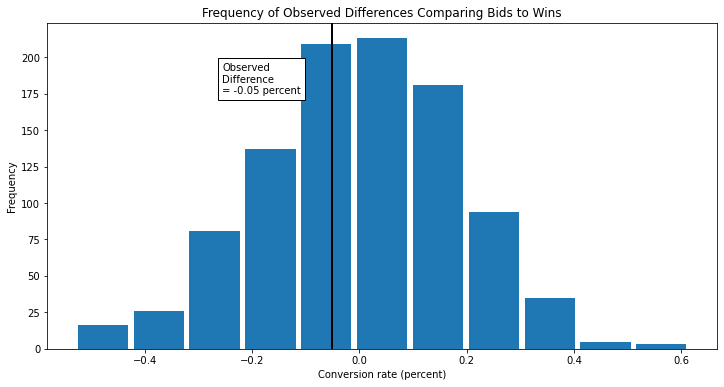

In [45]:
make_perm_hist(pt_diffs,
               obs_pct_diff,
               'Frequency of Observed Differences Comparing Bids to Wins',
               [5*obs_pct_diff, 175])

In [46]:
np.mean([diff > obs_pct_diff for diff in pt_diffs])

0.609

In [47]:
def calc_pVal(df):
    survivors = np.array([[df.iloc[0][1], df.iloc[0][0] - df.iloc[0][1]],
                         [df.iloc[1][1], df.iloc[1][0] - df.iloc[1][1]]])
    chi2, pval, df2, _ = scs.chi2_contingency(survivors)
    
    return pval

In [48]:
calc_pVal(conv_df[['bids', 'wins']])

0.7841564209738942

In [49]:
pt_diffs, obs_pct_diff = get_pt_diffs(conv_df[['wins', 'conversions']])

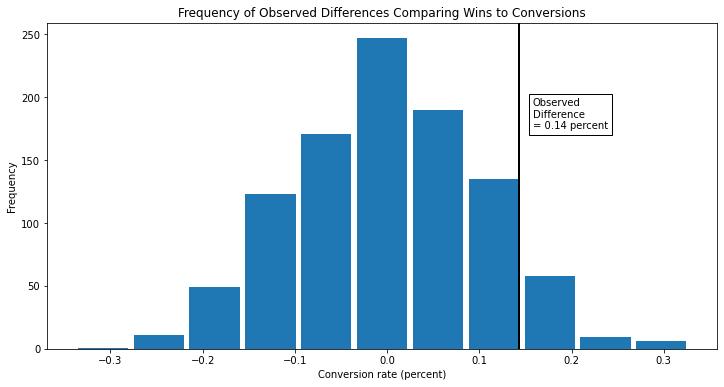

In [50]:
make_perm_hist(pt_diffs,
               obs_pct_diff,
               'Frequency of Observed Differences Comparing Wins to Conversions',
               [1.1*obs_pct_diff, 175])

In [51]:
np.mean([diff > obs_pct_diff for diff in pt_diffs])

0.073

In [52]:
calc_pVal(conv_df[['wins', 'conversions']])

0.16690884512421925